# 1. Dataset
## 1.1 Database Features


| Attribute              | Description                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| A - fighter1           | Name of the first fighter.                                                  |
| B - fighter2           | Name of the second fighter.                                                 |
| C - event              | Name of the UFC event where the fight took place.                           |
| D - fight_outcome      | Indicates which fighter won the fight.                                      |
| E - origin_fight_url   | URL linking to the original source of the fight details.                    |
| F - fighter1_Name      | Full name of fighter 1.                                                     |
| G - fighter1_Nickname  | Nickname of fighter 1.                                                      |
| H - fighter1_Record    | Fight record (wins-losses-draws) of fighter 1.                              |
| I - fighter1_Height    | Height of fighter 1.                                                        |
| J - fighter1_Weight    | Weight of fighter 1.                                                        |
| K - fighter1_Reach     | Reach of fighter 1.                                                         |
| L - fighter1_Stance    | Fighting stance of fighter 1 (e.g., Orthodox, Southpaw).                    |
| M - fighter1_DOB       | Date of birth of fighter 1.                                                 |
| N - fighter1_SLpM      | Significant strikes landed per minute by fighter 1.                         |
| O - fighter1_StrAcc    | Striking accuracy of fighter 1.                                             |
| P - fighter1_SApM      | Significant strikes absorbed per minute by fighter 1.                       |
| Q - fighter1_StrDef    | Striking defense percentage of fighter 1.                                   |
| R - fighter1_TDAvg     | Average takedowns per 15 minutes for fighter 1.                             |
| S - fighter1_TDAcc     | Takedown accuracy of fighter 1.                                             |
| T - fighter1_TDDef     | Takedown defense percentage of fighter 1.                                   |
| U - fighter1_SubAvg    | Average number of submissions attempted per 15 minutes by fighter 1.        |
| V - fighter2_Name      | Full name of fighter 2.                                                     |
| W - fighter2_Nickname  | Nickname of fighter 2.                                                      |
| X - fighter2_Record    | Fight record (wins-losses-draws) of fighter 2.                              |
| Y - fighter2_Height    | Height of fighter 2.                                                        |
| Z - fighter2_Weight    | Weight of fighter 2.                                                        |
| AA - fighter2_Reach    | Reach of fighter 2.                                                         |
| AB - fighter2_Stance   | Fighting stance of fighter 2 (e.g., Orthodox, Southpaw).                    |
| AC - fighter2_DOB      | Date of birth of fighter 2.                                                 |
| AD - fighter2_SLpM     | Significant strikes landed per minute by fighter 2.                         |
| AE - fighter2_StrAcc   | Striking accuracy of fighter 2.                                             |
| AF - fighter2_SApM     | Significant strikes absorbed per minute by fighter 2.                       |
| AG - fighter2_StrDef   | Striking defense percentage of fighter 2.                                   |
| AH - fighter2_TDAvg    | Average takedowns per 15 minutes for fighter 2.                             |
| AI - fighter2_TDAcc    | Takedown accuracy of fighter 2.                                             |
| AJ - fighter2_TDDef    | Takedown defense percentage of fighter 2.                                   |
| AK - fighter2_SubAvg   | Average number of submissions attempted per 15 minutes by fighter 2.        |


Using 18 difference features: ['diff_TDAcc', 'diff_StrAcc', 'diff_SubAvg', 'diff_StrDef', 'diff_Age', 'diff_SApM', 'diff_SLpM', 'diff_Reach', 'diff_TDAvg', 'diff_Height_in', 'diff_Draws', 'diff_TDDef', 'diff_Weight', 'diff_Wins', 'diff_Losses', 'diff_Stance_Orthodox', 'diff_Stance_Southpaw', 'diff_Stance_Switch']

Top 10 features selected by RFE: ['diff_TDAvg', 'diff_StrAcc', 'diff_Losses', 'diff_StrDef', 'diff_Age', 'diff_SApM', 'diff_SLpM', 'diff_Wins', 'diff_Weight', 'diff_TDDef']

Model Performance with Top Features:
Accuracy: 0.6915
AUC: 0.7676

--- Most Significant Features ---
                 feature   coef  odds_ratio     pval
1            diff_StrAcc  0.116       1.123  0.00165
12           diff_Weight  0.081       1.084   0.0144
3            diff_StrDef  0.085       1.089    0.025
7             diff_Reach  0.064       1.066    0.114
10            diff_Draws -0.052       0.950    0.115
2            diff_SubAvg  0.041       1.042    0.223
0             diff_TDAcc -0.038       

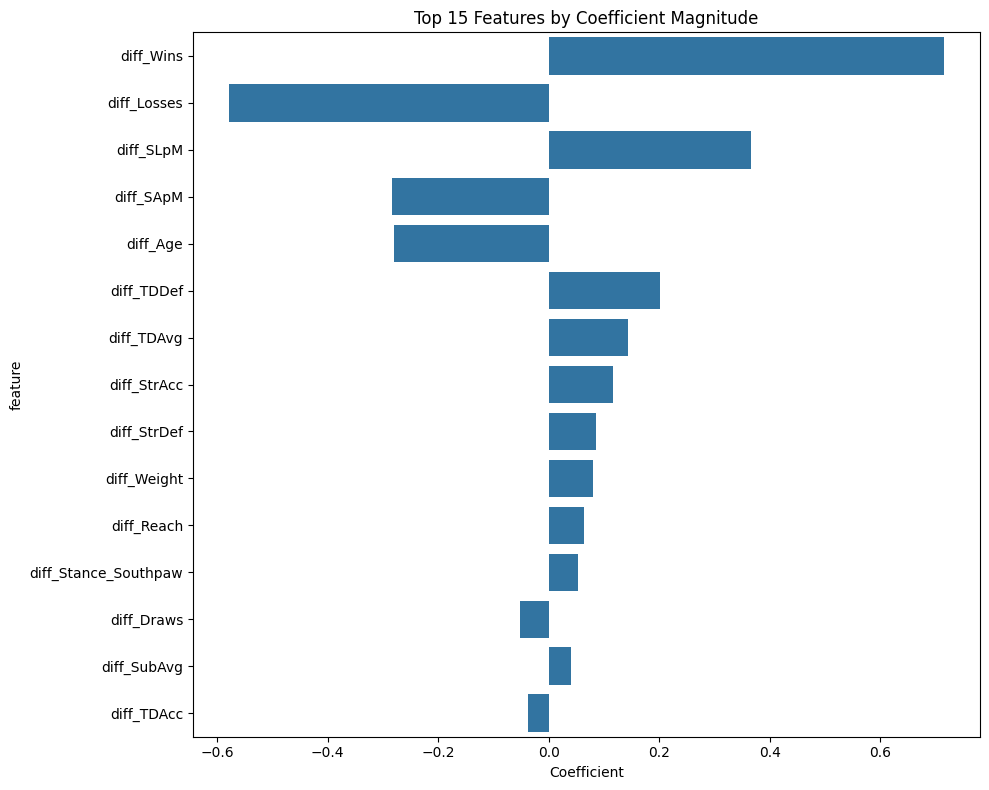

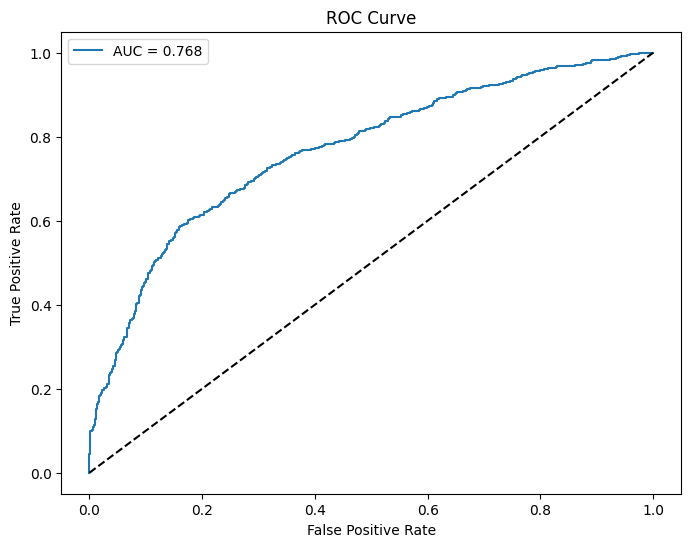

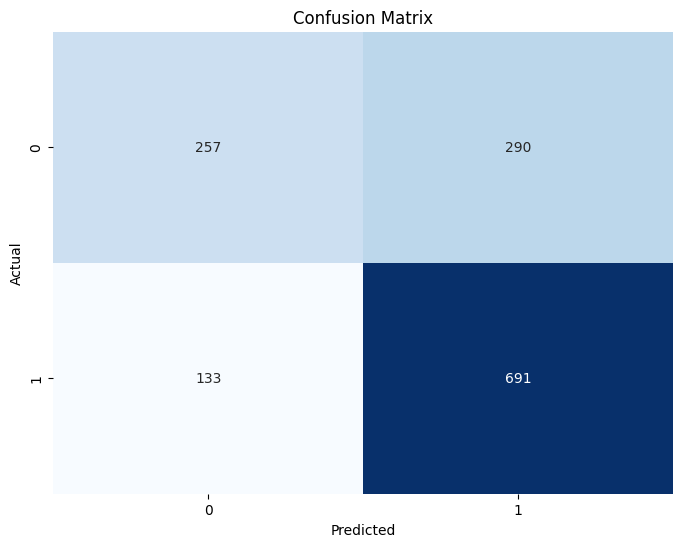

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings('ignore')

# Load data (adjust path as needed)
df = pd.read_csv('../Data/ufc_fights_cleaned.csv')

# 1. ENHANCED FEATURE ENGINEERING
# ------------------------------

# Create difference features for all numeric columns
numeric_cols = ['SLpM', 'StrAcc', 'SApM', 'StrDef', 'TDAvg', 'TDAcc', 'TDDef', 'SubAvg']
for col in numeric_cols:
    df[f'diff_{col}'] = df[f'fighter1_{col}'] - df[f'fighter2_{col}']

# Create age difference feature (if DOB is available)
if 'fighter1_DOB' in df.columns and 'fighter2_DOB' in df.columns:
    try:
        df['fighter1_age'] = pd.to_datetime('today') - pd.to_datetime(df['fighter1_DOB'])
        df['fighter2_age'] = pd.to_datetime('today') - pd.to_datetime(df['fighter2_DOB'])
        df['diff_age'] = (df['fighter1_age'].dt.days - df['fighter2_age'].dt.days) / 365.25
    except:
        print("Couldn't process DOB columns, skipping age difference")

# Handle stance differences (as you were doing)
for st in ['Open stance', 'Orthodox', 'Southpaw', 'Switch']:
    st_clean = st.replace(" ", "_")
    if f'fighter1_Stance_{st_clean}' in df.columns and f'fighter2_Stance_{st_clean}' in df.columns:
        df[f'diff_Stance_{st_clean}'] = (
            df[f'fighter1_Stance_{st_clean}'].astype(int) - 
            df[f'fighter2_Stance_{st_clean}'].astype(int)
        )

# Create reach and height advantage features
if 'fighter1_Reach' in df.columns and 'fighter2_Reach' in df.columns:
    df['diff_Reach'] = df['fighter1_Reach'] - df['fighter2_Reach']

if 'fighter1_Height' in df.columns and 'fighter2_Height' in df.columns:
    df['diff_Height'] = df['fighter1_Height'] - df['fighter2_Height']

# Experience difference (based on total fights)
if 'fighter1_Record' in df.columns and 'fighter2_Record' in df.columns:
    try:
        # Extract total fights from record (assuming format like "12-3-2")
        df['fighter1_total_fights'] = df['fighter1_Record'].apply(
            lambda x: sum(int(i) for i in str(x).split('-') if i.isdigit())
        )
        df['fighter2_total_fights'] = df['fighter2_Record'].apply(
            lambda x: sum(int(i) for i in str(x).split('-') if i.isdigit())
        )
        df['diff_experience'] = df['fighter1_total_fights'] - df['fighter2_total_fights']
    except:
        print("Couldn't process record columns, skipping experience difference")

# Get all difference columns
diff_cols = [c for c in df.columns if c.startswith('diff_')]
print(f"Using {len(diff_cols)} difference features: {diff_cols}")

# 2. PREPARE DATA
# --------------
X = df[diff_cols].copy()
y = df['fight_outcome']

# Handle missing values
X = X.fillna(X.median())

# Scale features for better model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42
)

# 3. FEATURE SELECTION AND IMPORTANCE
# ----------------------------------

# Method 1: Using Statsmodels for interpretable coefficients
X_train_sm = sm.add_constant(X_train)
model_sm = sm.Logit(y_train, X_train_sm).fit(disp=False)

# Create comprehensive stats table
stats = pd.DataFrame({
    'feature': model_sm.params.index,
    'coef': model_sm.params.values,
    'std_err': model_sm.bse.values,
    'z_value': model_sm.tvalues.values,
    'pval': model_sm.pvalues.values,
    'odds_ratio': np.exp(model_sm.params.values),
    'lower_ci': np.exp(model_sm.params.values - 1.96 * model_sm.bse.values),
    'upper_ci': np.exp(model_sm.params.values + 1.96 * model_sm.bse.values)
})

# Drop intercept and round values
stats = stats[stats['feature'] != 'const'].reset_index(drop=True)

# Format output
stats = stats.assign(
    coef = lambda df: df['coef'].round(3),
    std_err = lambda df: df['std_err'].round(3),
    z_value = lambda df: df['z_value'].round(3),
    pval = lambda df: df['pval'].apply(lambda p: f"{p:.3g}"),
    odds_ratio = lambda df: df['odds_ratio'].round(3),
    lower_ci = lambda df: df['lower_ci'].round(3),
    upper_ci = lambda df: df['upper_ci'].round(3)
)

# Sort by significance
stats_by_sig = stats.sort_values('pval')

# Method 2: Recursive Feature Elimination for finding optimal feature set
log_reg = LogisticRegression(max_iter=1000, random_state=42)
rfe = RFE(estimator=log_reg, n_features_to_select=10, step=1)
rfe.fit(X_train, y_train)

# Create RFE ranking DataFrame
rfe_results = pd.DataFrame({
    'feature': X_train.columns,
    'selected': rfe.support_,
    'ranking': rfe.ranking_
})
rfe_results = rfe_results.sort_values('ranking')

# 4. MODEL PERFORMANCE ASSESSMENT
# -----------------------------

# Train model on selected features
selected_features = rfe_results[rfe_results['selected']]['feature'].tolist()
print(f"\nTop 10 features selected by RFE: {selected_features}")

# Train model with selected features
log_reg.fit(X_train[selected_features], y_train)
y_pred = log_reg.predict(X_test[selected_features])
y_prob = log_reg.predict_proba(X_test[selected_features])[:, 1]

# Compute performance metrics
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
print(f"\nModel Performance with Top Features:")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")

# 5. VISUALIZATIONS
# --------------

# Plot 1: Feature importance by coefficient magnitude
plt.figure(figsize=(10, 8))
coef_stats = stats.sort_values('coef', key=abs, ascending=False).head(15)
sns.barplot(x='coef', y='feature', data=coef_stats)
plt.title('Top 15 Features by Coefficient Magnitude')
plt.xlabel('Coefficient')
plt.tight_layout()
plt.savefig('feature_importance_coef.png')

# Plot 2: ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('roc_curve.png')

# Plot 3: Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

# 6. SUMMARY OUTPUT
# ---------------

# Display the most important features by statistical significance
print("\n--- Most Significant Features ---")
print(stats_by_sig[['feature', 'coef', 'odds_ratio', 'pval']].head(10))

# Display the most important features by odds ratio magnitude
print("\n--- Features with Largest Effect Size ---")
print(stats.sort_values('odds_ratio', ascending=False)[['feature', 'coef', 'odds_ratio', 'pval']].head(10))

# Export results to CSV
stats.to_csv('feature_importance_stats.csv', index=False)
rfe_results.to_csv('rfe_feature_selection.csv', index=False)

# Comprehensive analysis of the top predictors
print("\n=== TOP FIGHT OUTCOME PREDICTORS ANALYSIS ===")
print("These features are the strongest predictors of fight outcomes:")

# Get top 5 significant predictors that are also selected by RFE
top_predictors = stats_by_sig[stats_by_sig['feature'].isin(selected_features)].head(5)

for _, row in top_predictors.iterrows():
    feature = row['feature']
    direction = "increases" if row['coef'] > 0 else "decreases"
    print(f"\n{feature}:")
    print(f"  - Coefficient: {row['coef']} (p-value: {row['pval']})")
    print(f"  - Odds Ratio: {row['odds_ratio']} (95% CI: {row['lower_ci']:.3f}-{row['upper_ci']:.3f})")
    print(f"  - Interpretation: A one standard deviation advantage in this feature {direction}")
    print(f"    the odds of fighter 1 winning by a factor of {abs(row['odds_ratio'] - 1):.3f}x")